# NVIDIA Inference Server MNIST Example

This example shows how you can combine Seldon with the NVIDIA Inference Server. We will use a Seldon TensorRT proxy model image that will forward Seldon internal microservice prediction calls out to an external TensorRT Inference Server.

The example will use the MNIST digit classification task with a pre-trained CAFFE2 model.

A Seldon transformer will transform the inputs before sending to the Proxy which will forward the request to the Nvidia Inference Server.

This example will:

 * Show the packaging of the components using S2I and a step by step local testing of these via Docker
 * Show running the example in Seldon Core on GCP with an embedded Nvidia Inference Server
 

## Setup

In [23]:
%matplotlib inline
import requests
from random import randint,random
import json
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import sys
sys.path.append("../../../notebooks")
from visualizer import get_graph

In [58]:
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap=plt.cm.gray_r, interpolation='nearest')
    return plt

def download_mnist():
    return input_data.read_data_sets("MNIST_data/", one_hot = True)

def rest_predict_request(endpoint,data):
    request = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+endpoint+"/predict",
                data={"json":json.dumps(request),"isDefault":True})
    return response.json()   

def rest_transform_input_request(endpoint,data):
    request = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+endpoint+"/transform-input",
                data={"json":json.dumps(request),"isDefault":True})
    return response.json()   

def rest_transform_output_request(endpoint,data):
    request = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+endpoint+"/transform-output",
                data={"json":json.dumps(request),"isDefault":True})
    return response.json()   

def rest_request_ambassador(deploymentName,endpoint="localhost:8003",arr=None):
    payload = {"data":{"names":["a","b"],"tensor":{"shape":[1,784],"values":arr.tolist()}}}
    response = requests.post(
                "http://"+endpoint+"/seldon/seldon/"+deploymentName+"/api/v0.1/predictions",
                json=payload)
    print(response.status_code)
    print(response.text)


def gen_mnist_data(mnist):
    batch_xs, batch_ys = mnist.train.next_batch(1)
    chosen=0
    gen_image(batch_xs[chosen]).show()
    data = batch_xs[chosen].reshape((1,784))
    return data


In [25]:
mnist = download_mnist()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

## Create an Nvidia Model Repository

Fetch pretrained MNIST model ready for serving and place in model repository

In [1]:
!mkdir -p tensorrt_mnist/1

In [43]:
!wget -O tensorrt_mnist/1/model.plan http://seldon-public.s3.amazonaws.com/nvidia-mnist-model/model.plan

--2019-04-16 18:35:23--  http://seldon-public.s3.amazonaws.com/nvidia-mnist-model/model.plan
Resolving seldon-public.s3.amazonaws.com (seldon-public.s3.amazonaws.com)... 52.218.49.89
Connecting to seldon-public.s3.amazonaws.com (seldon-public.s3.amazonaws.com)|52.218.49.89|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1731864 (1.7M) [binary/octet-stream]
Saving to: ‘tensorrt_mnist/1/model.plan’

tensorrt_mnist/1/mo 100%[===================>]   1.65M   846KB/s    in 2.0s    

2019-04-16 18:35:25 (846 KB/s) - ‘tensorrt_mnist/1/model.plan’ saved [1731864/1731864]



To run your Mvidia Inference Server you will need to upload to a google bucket the model repository in mnsit_tensorrt_model. Follow the steps below:

In [44]:
# CHANGE THIS TO YOUR OWN CHOSEN GOOGLE BUCKET NAME
%env MODEL_REPOSITORY_BUCKET=gs://seldon-inference-server-model-store

env: MODEL_REPOSITORY_BUCKET=gs://seldon-inference-server-model-store


In [45]:
!gsutil mb ${MODEL_REPOSITORY_BUCKET}

Creating gs://seldon-inference-server-model-store/...
ServiceException: 409 Bucket seldon-inference-server-model-store already exists.


In [46]:
!gsutil cp -r tensorrt_mnist ${MODEL_REPOSITORY_BUCKET}

Copying file://tensorrt_mnist/config.pbtxt [Content-Type=application/octet-stream]...
Copying file://tensorrt_mnist/mnist_labels.txt [Content-Type=text/plain]...     
Copying file://tensorrt_mnist/1/model.plan [Content-Type=application/octet-stream]...
- [3 files][  1.7 MiB/  1.7 MiB]                                                
Operation completed over 3 objects/1.7 MiB.                                      


## Create your Nvidia Inference Server

For example:

 * Follow the steps in the [Kubeflow guide](https://www.kubeflow.org/docs/components/serving/tritoninferenceserver/) to create your Nvidia Inference Server 
   * You will need to use the Google Bucket location

## Package and run a Transformer and Nvidia Proxy

We will use a Seldon Transformer to remove the training-set mean values from the input features and rehsape the output as the prediction comes back.

In [17]:
!pygmentize MnistTransformer.py

import numpy as np

MEANS=np.array([255.0,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254,254,254,253,252,252,251,251,252,252,253,254,254,255,255,255,255,255,255,255,255,255,255,255,255,255,254,254,253,251,249,248,245,243,242,242,243,246,248,251,253,254,255,255,255,255,255,255,255,255,255,255,255,254,253,250,247,242,235,228,220,213,210,211,216,224,232,240,246,251,253,254,255,255,255,255,255,255,255,255,254,251,248,242,234,223,211,196,181,170,164,166,175,189,205,221,233,243,248,252,254,255,255,255,255,255,255,254,252,248,241,231,217,202,184,166,149,136,131,134,143,159,180,201,220,234,243,249,253,255,255,255,255,255,254,253,249,243,233,219,201,181,161,143,130,122,120,122,129,141,161,185,208,227,240,248,252,254,255,255,255,255,254,251,246,238,226,208,187,164,146,135,131,132,133,13

In [12]:
!s2i build . seldonio/seldon-core-s2i-python3:1.2.4 mnist-caffe2-transformer:0.1

---> Installing application source...
Build completed successfully


In [29]:
!docker run --name "mnist-transformer" -d --rm -p 5000:5000 mnist-caffe2-transformer:0.1

f2ce59df93344847d070d4218d6bccb5a7d1dab48120967a2e213435a69dce9c


Run the Seldon Nvidia Inference Server Proxy Model.

** CHANGE THE IP ADDRESS BELOW TO THAT OF YOUR RUNNING NVIDIA SERVER **

In [30]:
!docker run --name "tensorrt-proxy" -d --rm -p 5001:5001 \
    -e PREDICTIVE_UNIT_SERVICE_PORT=5001 \
    -e PREDICTIVE_UNIT_PARAMETERS='[{"name":"url","type":"STRING","value":"35.204.115.6:8000"},{"name":"model_name","type":"STRING","value":"tensorrt_mnist"},{"name":"protocol","type":"STRING","value":"HTTP"}]' \
    seldonio/nvidia-inference-server-proxy:0.1

3bcca7450fadcbb8d54f90af0b40c32f26b875938b742451a4365ced0c5d3ccf


In [31]:
TRANSFORMER_URL="localhost:5000"
PREDICTOR_URL="localhost:5001"

In the next few steps we illustrate each step by step process and test that out on our running Docker containers.

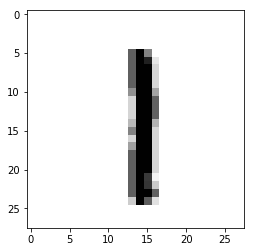

(1, 28, 28)


In [32]:
data = gen_mnist_data(mnist)
response = rest_transform_input_request(TRANSFORMER_URL,data)
transformed = np.array(response['data']['ndarray'])
print(transformed.shape)

In [33]:
response = rest_predict_request(PREDICTOR_URL,transformed)
predictions = np.array(response["data"]["ndarray"])
print(predictions)

[[[[6.36274109e-08]]

  [[9.99982357e-01]]

  [[1.35594092e-07]]

  [[2.00526298e-08]]

  [[1.17960089e-05]]

  [[8.07224509e-08]]

  [[4.73712625e-08]]

  [[4.78241873e-06]]

  [[6.21992911e-07]]

  [[9.71163061e-08]]]]


In [34]:
response = rest_transform_output_request(TRANSFORMER_URL,predictions)
print(response)

{'data': {'names': None, 'ndarray': [[6.362741089560586e-08, 0.9999823570251465, 1.3559409239860543e-07, 2.005262977888833e-08, 1.1796008948294912e-05, 8.072245094581376e-08, 4.737126246823209e-08, 4.782418727700133e-06, 6.219929105100164e-07, 9.711630610809152e-08]]}}


In [35]:
!docker rm -f mnist-transformer
!docker rm -f tensorrt-proxy

mnist-transformer
tensorrt-proxy


## Test From GCP Cluster

### Set up GCP Kubernetes Cluster

To run the steps below you will need to:

 1. Create a GCP Cluster with a GPU node pool with Nvidia V100 GPUs
 2. Enable CUDA on the GPU nodes
 3. Add an Image Pull Secret so you can download the Nvidia Inference Server 
 
#### Create a GCP Cluster
 This can be done from the Google console or via the command line as shown below. Change the cluster name and zones as appropriate for your setup.

```
 gcloud container clusters create myinferenceserver --num-nodes=2 --region=europe-west4-a
 gcloud config set container/cluster myinferenceserver
 gcloud container node-pools create gpu-pool --num-nodes=1 --machine-type=n1-standard-8 --accelerator type=nvidia-tesla-v100,count=1 --region=europe-west4-a
 gcloud container clusters get-credentials myinferenceserver
```

#### Enable CUDA on GPU Nodes

To enable the CUDA drivers on your GPU nodes run:

```
kubectl apply -f https://raw.githubusercontent.com/GoogleCloudPlatform/container-engine-accelerators/stable/nvidia-driver-installer/cos/daemonset-preloaded.yaml
```

#### Create Image Pull Secret for the Nvidia Repository

 * [Sign up to the NVIDIA GPU Cloud and get an API Key](https://ngc.nvidia.com/signup)
 * Create a kubernetes secret
 

In [1]:
!kubectl create namespace seldon

namespace/seldon created


In [3]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "gke_seldon-demos_europe-west4-a_myinferenceserver" modified.


In [37]:
!kubectl create secret docker-registry ngc \
    --docker-server=nvcr.io \
    --docker-username=\$oauthtoken \
    --docker-password=${NVIDIA_API_KEY} --docker-email=${NVIDIA_CLOUD_EMAIL}

secret/ngc created


## Run MNIST Inference Graph

## Setup Seldon Core

Use the setup notebook to [Setup Cluster](../../../notebooks/seldon_core_setup.ipynb#Setup-Cluster) with [Ambassador Ingress](../../../notebooks/seldon_core_setup.ipynb#Ambassador) and [Install Seldon Core](../../seldon_core_setup.ipynb#Install-Seldon-Core). Instructions [also online](./seldon_core_setup.html).

In [2]:
!helm install nvidia-mnist nvidia-mnist --set tfserving.model_base_path=${MODEL_REPOSITORY_BUCKET}

NAME: nvidia-mnist
LAST DEPLOYED: Wed Dec  4 10:31:29 2019
NAMESPACE: default
STATUS: deployed
REVISION: 1
TEST SUITE: None


In [20]:
!helm template nvidia-mnist nvidia-mnist --namespace seldon --set tfserving.model_base_path=${MODEL_REPOSITORY_BUCKET} > mnist.json

In [21]:
!sed '1,2d' mnist.json > tmp.json

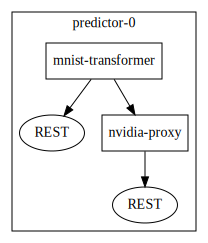

In [26]:
get_graph("tmp.json")

In [27]:
!pygmentize mnist.json

---
# Source: nvidia-mnist/templates/mnist_nvidia_deployment.json
{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "nvidia-mnist",
	"namespace": "seldon"
    },
    "spec": {
        "name": "caffe2-mnist",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "seldonio/mnist-caffe2-transformer:0.1",
                                "name": "mnist-transformer"
                            },
                            {
                                "image": "seldonio/nvidia-inference-server-proxy:0.1",
                                "name": "nvidia-proxy"
                            },
			    {
				"args": [
				    "--model-store=gs://seldon-inference-server-model-store"
				],
				"command"

**Port forward Ambassador**

```
kubectl port-forward $(kubectl get pods -n seldon -l app.kubernetes.io/name=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon 8003:8080
```

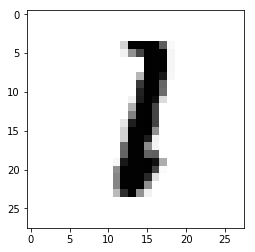

200
{
  "meta": {
    "puid": "pvms7jocoktb37gkb8hpj4cej0",
    "tags": {
    },
    "routing": {
      "mnist-transformer": -1
    },
    "requestPath": {
      "nvidia-proxy": "seldonio/nvidia-inference-server-proxy:0.1",
      "mnist-transformer": "seldonio/mnist-caffe2-transformer:0.1"
    },
    "metrics": []
  },
  "data": {
    "names": ["t:0", "t:1", "t:2", "t:3", "t:4", "t:5", "t:6", "t:7", "t:8", "t:9"],
    "tensor": {
      "shape": [1, 10, 1, 1],
      "values": [2.5883252874336904E-7, 0.9981641173362732, 2.274509461130947E-5, 8.619469736004248E-5, 3.228335117455572E-6, 2.4672864640251646E-8, 4.060555909290997E-7, 0.0016722471918910742, 5.0836355512728915E-5, 1.2317170394737786E-8]
    }
  }
}


In [59]:
data = gen_mnist_data(mnist)
data = data.reshape((784))
rest_request_ambassador("nvidia-mnist",endpoint="localhost:8003",arr=data)

## Analytics and Load Test

In [21]:
!helm install seldon-core-analytics ../../../helm-charts/seldon-core-analytics \
    --set grafana_prom_admin_password=password \
    --set persistence.enabled=false \
    --namespace seldon

NAME:   seldon-core-analytics
LAST DEPLOYED: Mon Sep 24 14:40:46 2018
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1beta1/ClusterRoleBinding
NAME        AGE
prometheus  0s

==> v1/Job
NAME                            DESIRED  SUCCESSFUL  AGE
grafana-prom-import-dashboards  1        0           0s

==> v1/Service
NAME                      TYPE       CLUSTER-IP     EXTERNAL-IP  PORT(S)       AGE
alertmanager              ClusterIP  10.39.243.208  <none>       80/TCP        0s
grafana-prom              NodePort   10.39.246.121  <none>       80:30588/TCP  0s
prometheus-node-exporter  ClusterIP  None           <none>       9100/TCP      0s
prometheus-seldon         ClusterIP  10.39.253.10   <none>       80/TCP        0s

==> v1beta1/DaemonSet
NAME                      DESIRED  CURRENT  READY  UP-TO-DATE  AVAILABLE  NODE SELECTOR  AGE
prometheus-node-exporter  1        1        0      1           0          <none>         0s

==> v1/ConfigMap
NAME                       DATA  AGE
alertm

In [22]:
!kubectl label nodes $(kubectl get nodes -o jsonpath='{.items[0].metadata.name}') role=locust

node "gke-cluster-1-default-pool-5e22f4e3-djd7" labeled


In [23]:
!helm install loadtest seldon-core-loadtesting \
    --namespace seldon \
    --repo https://storage.googleapis.com/seldon-charts \
    --set locust.script=mnist_rest_locust.py \
    --set locust.host=http://caffe2-mnist:8000 \
    --set oauth.enabled=false \
    --set locust.hatchRate=1 \
    --set locust.clients=1 \
    --set loadtest.sendFeedback=1 \
    --set locust.minWait=0 \
    --set locust.maxWait=0 \
    --set replicaCount=1 \
    --set data.size=784


NAME:   loadtest
LAST DEPLOYED: Mon Sep 24 14:40:53 2018
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/ReplicationController
NAME             DESIRED  CURRENT  READY  AGE
locust-slave-1   1        1        0      0s
locust-master-1  1        1        0      0s

==> v1/Service
NAME             TYPE      CLUSTER-IP    EXTERNAL-IP  PORT(S)                                       AGE
locust-master-1  NodePort  10.39.254.17  <none>       5557:31880/TCP,5558:30185/TCP,8089:32570/TCP  0s

==> v1/Pod(related)
NAME                   READY  STATUS             RESTARTS  AGE
locust-slave-1-p5n6f   0/1    ContainerCreating  0         0s
locust-master-1-ksk7g  0/1    ContainerCreating  0         0s




You should port-foward the grafana dashboard

```
kubectl port-forward $(kubectl get pods -n seldon -l app=grafana-prom-server -o jsonpath='{.items[0].metadata.name}') -n seldon 3000:3000
```

You can then view an analytics dashboard inside the cluster at http://localhost:3000/dashboard/db/prediction-analytics?refresh=5s&orgId=1. Your IP address may be different. get it via minikube ip. Login with:

    Username : admin

    password : password (as set when starting seldon-core-analytics above)